In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print('Libraries imported!')

Libraries imported!


In [ ]:
# importing training and test dataset from github repo

df_train = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/Data/train.csv", encoding='UTF-8')

df_test = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/Data/test.csv", encoding='UTF-8')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

In [ ]:
# checking for null values for training data
null_check = df_train.isnull().sum()
for key,value in null_check.iteritems():
  if value > 0:
    print(key,",",value)

LotFrontage , 259
Alley , 1369
MasVnrType , 8
MasVnrArea , 8
BsmtQual , 37
BsmtCond , 37
BsmtExposure , 38
BsmtFinType1 , 37
BsmtFinType2 , 38
Electrical , 1
FireplaceQu , 690
GarageType , 81
GarageYrBlt , 81
GarageFinish , 81
GarageQual , 81
GarageCond , 81
PoolQC , 1453
Fence , 1179
MiscFeature , 1406


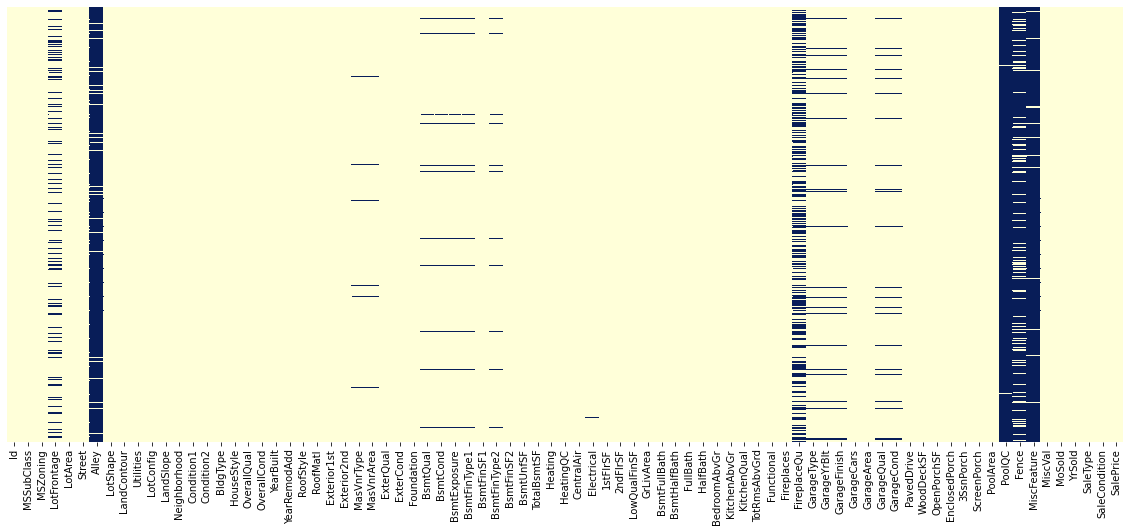

In [ ]:
# heatmap of null

plt.figure(figsize=(20,8))
sns.heatmap(df_train.isnull(),yticklabels=False, cmap="YlGnBu", cbar=False)

In [ ]:
# data types and information of df_train (training dataset)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# checking for null values
null_check_test = df_test.isnull().sum()
for key,value in null_check_test.iteritems():
  if value > 0:
    print(key,",",value)

MSZoning , 4
LotFrontage , 227
Alley , 1352
Utilities , 2
Exterior1st , 1
Exterior2nd , 1
MasVnrType , 16
MasVnrArea , 15
BsmtQual , 44
BsmtCond , 45
BsmtExposure , 44
BsmtFinType1 , 42
BsmtFinSF1 , 1
BsmtFinType2 , 42
BsmtFinSF2 , 1
BsmtUnfSF , 1
TotalBsmtSF , 1
BsmtFullBath , 2
BsmtHalfBath , 2
KitchenQual , 1
Functional , 2
FireplaceQu , 730
GarageType , 76
GarageYrBlt , 78
GarageFinish , 78
GarageCars , 1
GarageArea , 1
GarageQual , 78
GarageCond , 78
PoolQC , 1456
Fence , 1169
MiscFeature , 1408
SaleType , 1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
# fill na values of columns of training dataset with mean value if data is of float type otherwise we're taking the mode.

df_train['LotFrontage'] = df_train['LotFrontage'].fillna(df_train['LotFrontage'].mean())
df_train['MasVnrType'] = df_train['MasVnrType'].fillna(df_train['MSZoning'].mode()[0])
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(df_train['MasVnrArea'].mean())
df_train['BsmtQual'] = df_train['BsmtQual'].fillna(df_train['BsmtQual'].mode()[0])
df_train['BsmtCond'] = df_train['BsmtCond'].fillna(df_train['BsmtCond'].mode()[0])
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna(df_train['BsmtExposure'].mode()[0])
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna(df_train['BsmtFinType1'].mode()[0])
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna(df_train['BsmtFinType2'].mode()[0])
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])
df_train['GarageType'] = df_train['GarageType'].fillna(df_train['GarageType'].mode()[0])
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['GarageYrBlt'].mean())
df_train['GarageFinish'] = df_train['GarageFinish'].fillna(df_train['GarageFinish'].mode()[0])
df_train['GarageQual'] = df_train['GarageQual'].fillna(df_train['GarageQual'].mode()[0])
df_train['GarageCond'] = df_train['GarageCond'].fillna(df_train['GarageCond'].mode()[0])

In [ ]:
# fill na values of columns of test dataset with mean value if data is of float type otherwise we're taking the mode.

df_test['LotFrontage'] = df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean())
df_test['MSZoning'] = df_test['MSZoning'].fillna(df_test['MSZoning'].mode()[0])
df_test['MasVnrType'] = df_test['MasVnrType'].fillna(df_test['MSZoning'].mode()[0])
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].mean())
df_test['BsmtQual'] = df_test['BsmtQual'].fillna(df_test['BsmtQual'].mode()[0])
df_test['BsmtCond'] = df_test['BsmtCond'].fillna(df_test['BsmtCond'].mode()[0])
df_test['BsmtExposure'] = df_test['BsmtExposure'].fillna(df_test['BsmtExposure'].mode()[0])
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna(df_test['BsmtFinType1'].mode()[0])
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].fillna(df_test['BsmtFinType2'].mode()[0])
df_test['Electrical'] = df_test['Electrical'].fillna(df_test['Electrical'].mode()[0])
df_test['GarageType'] = df_test['GarageType'].fillna(df_test['GarageType'].mode()[0])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_test['GarageYrBlt'].mean())
df_test['GarageFinish'] = df_test['GarageFinish'].fillna(df_test['GarageFinish'].mode()[0])
df_test['GarageQual'] = df_test['GarageQual'].fillna(df_test['GarageQual'].mode()[0])
df_test['GarageCond'] = df_test['GarageCond'].fillna(df_test['GarageCond'].mode()[0])
df_test['Utilities'] = df_test['Utilities'].fillna(df_test['Utilities'].mode()[0])
df_test['Exterior1st'] = df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0])
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0])
df_test['BsmtFinSF1'] = df_test['BsmtFinSF1'].fillna(df_test['BsmtFinSF1'].mean())
df_test['BsmtFinSF2'] = df_test['BsmtFinSF2'].fillna(df_test['BsmtFinSF2'].mean())
df_test['BsmtUnfSF'] = df_test['BsmtUnfSF'].fillna(df_test['BsmtUnfSF'].mean())
df_test['TotalBsmtSF'] = df_test['TotalBsmtSF'].fillna(df_test['TotalBsmtSF'].mean())
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].fillna(df_test['BsmtFullBath'].mean())
df_test['BsmtHalfBath'] = df_test['BsmtHalfBath'].fillna(df_test['BsmtHalfBath'].mean())
df_test['KitchenQual'] = df_test['KitchenQual'].fillna(df_test['KitchenQual'].mode()[0])
df_test['Functional'] = df_test['Functional'].fillna(df_test['Functional'].mode()[0])
df_test['GarageCars'] = df_test['GarageCars'].fillna(df_test['GarageCars'].mode()[0])
df_test['GarageArea'] = df_test['GarageArea'].fillna(df_test['GarageArea'].mean())
df_test['SaleType'] = df_test['SaleType'].fillna(df_test['SaleType'].mode()[0])

In [ ]:
# dropping columns from both training and test data which contains most of their values as null

df_train.drop(['Id','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)
df_test.drop(['Id','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

In [ ]:
# shape of the dataset after intial cleaning

print("Shape of training data: ", df_train.shape)
print("Shape of test data: ", df_test.shape)

Shape of training data:  (1460, 75)
Shape of test data:  (1459, 74)


## Some Exploration to learn about the correlations

In [ ]:
# summary statistics of SalePrice column in df_train

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Histogram of Sale Price')

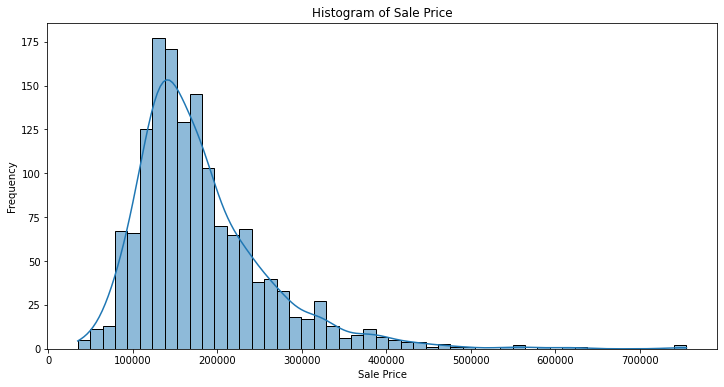

In [ ]:
# plotting histogram of SalePrice column in df_train

plt.figure(figsize=(12,6))
sns.histplot(df_train["SalePrice"], kde=True)
plt.ylabel('Frequency')
plt.xlabel('Sale Price')
plt.title('Histogram of Sale Price')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


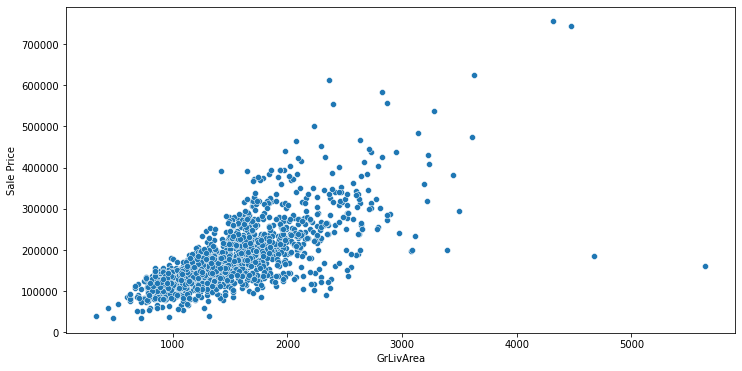

In [ ]:
# scatter plot of GrLivArea vs SalePrice

plt.figure(figsize=(12,6))
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel("Sale Price")
plt.xlabel("GrLivArea")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


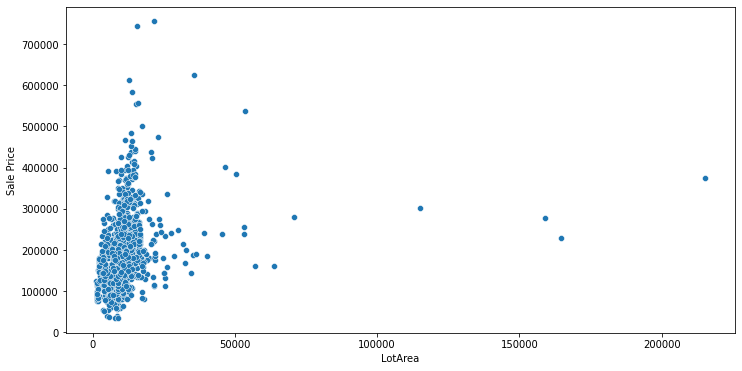

In [ ]:
# scatter plot of LotArea vs SalePrice

plt.figure(figsize=(12,6))
sns.scatterplot(df_train['LotArea'], df_train['SalePrice'])
plt.ylabel("Sale Price")
plt.xlabel("LotArea")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


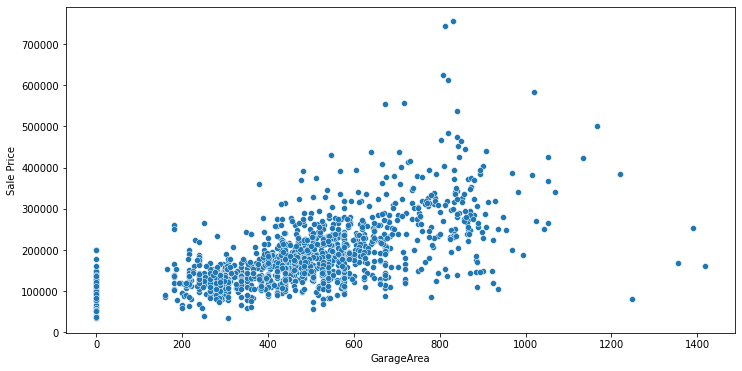

In [ ]:
# scatter plot of GarageArea vs SalePrice

plt.figure(figsize=(12,6))
sns.scatterplot(df_train['GarageArea'], df_train['SalePrice'])
plt.ylabel("Sale Price")
plt.xlabel("GarageArea")
plt.show()

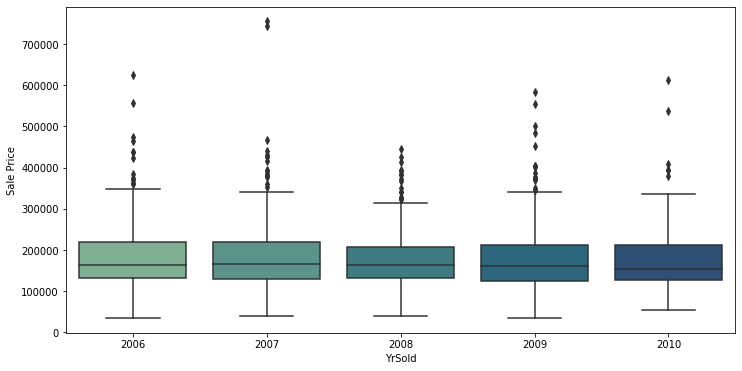

In [ ]:
# scatter plot of YrSold vs SalePrice

plt.figure(figsize=(12,6))
sns.boxplot(x="YrSold", y="SalePrice",data=df_train,palette="crest") 
plt.ylabel("Sale Price")
plt.xlabel("YrSold")
plt.show()

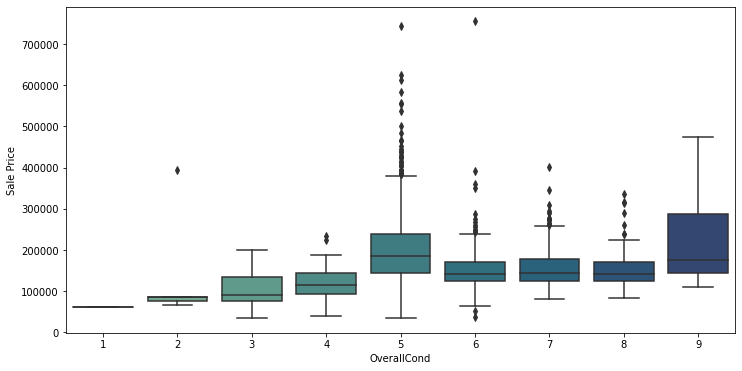

In [ ]:
# Box plot OverallCond vs SalePrice

plt.figure(figsize=(12,6))
sns.boxplot(x="OverallCond", y="SalePrice",data=df_train,palette="crest") 
plt.ylabel("Sale Price")
plt.xlabel("OverallCond")
plt.show()

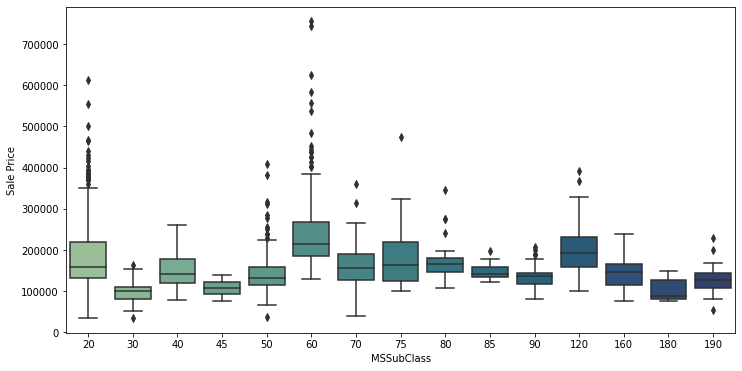

In [ ]:
# Box plot MSSubClass vs SalePrice

plt.figure(figsize=(12,6))
sns.boxplot(x="MSSubClass", y="SalePrice",data=df_train,palette="crest") 
plt.ylabel("Sale Price")
plt.xlabel("MSSubClass")
plt.show()

## Data Wrangling

In [ ]:
# Converting MSSublclass data to string (to keep them as categorical)

# df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
# df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)

In [ ]:
# Getting Age of the house from first build and from remodeling

df_train['AgeHouse'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['AgeFromRemodel'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_train['RemodelToBuild'] = df_train['YearRemodAdd'] - df_train['YearBuilt']

df_test['AgeHouse'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['AgeFromRemodel'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['RemodelToBuild'] = df_test['YearRemodAdd'] - df_test['YearBuilt']

# dropping YearBuilt and YearRemodAdd columns

df_train.drop(['YearBuilt','YearRemodAdd','YrSold'], axis=1, inplace=True)
df_test.drop(['YearBuilt','YearRemodAdd','YrSold'], axis=1, inplace=True)

In [ ]:
# Findng columns with categorical variables

column_cat = []

for c in df_train.columns:
  if df_train[c].dtype == 'O':
    column_cat.append(c)

print(column_cat)
len(column_cat)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


38

In [ ]:
# Getting all the columns names of test set to a list

df_t_columns = list(df_test.columns)
len(df_t_columns)

74

In [ ]:
# positioning the SalePrice column in its original position in training set

sale_price = df_train['SalePrice']
df_train = df_train[df_t_columns]
df_train['SalePrice'] = sale_price
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,AgeHouse,AgeFromRemodel,RemodelToBuild,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal,5,5,0,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal,31,31,0,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal,7,6,1,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml,91,36,55,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal,8,8,0,250000


In [ ]:
# concatenating training and test data.

train_test_df = pd.concat([df_train, df_test], axis=0)
train_test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,AgeHouse,AgeFromRemodel,RemodelToBuild,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal,5,5,0,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal,31,31,0,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal,7,6,1,223500.0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml,91,36,55,140000.0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal,8,8,0,250000.0


In [ ]:
# checking the tail part of the combined dataframe

train_test_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,AgeHouse,AgeFromRemodel,RemodelToBuild,SalePrice
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,Attchd,1977.721217,Unf,0.0,0.0,TA,TA,Y,0,0,0,0,0,0,0,6,WD,Normal,36,36,0,NaN
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.000000,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,WD,Abnorml,36,36,0,NaN
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.000000,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,WD,Abnorml,46,10,36,NaN
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,Attchd,1977.721217,Unf,0.0,0.0,TA,TA,Y,80,32,0,0,0,0,700,7,WD,Normal,14,14,0,NaN
1458,60,RL,74.0,9627,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,Attchd,1993.000000,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,0,11,WD,Normal,13,12,1,NaN


In [ ]:
# shape of combined df

train_test_df.shape

(2919, 75)

In [ ]:
def dummy(columns):
  df_train_test = train_test_df
  i=0
  for column in columns:
        
      print(column)
      df_temp=pd.get_dummies(train_test_df[column],drop_first=True)
        
      train_test_df.drop([column],axis=1,inplace=True)
      if i==0:
          df_train_test = df_temp.copy()
      else:  
          df_train_test = pd.concat([df_train_test, df_temp], axis=1)
      
      i=i+1
       
        
  df_train_test = pd.concat([train_test_df, df_train_test], axis=1)
        
  return df_train_test

In [ ]:
sale_price = df_train['SalePrice']

train_test_df.drop(columns=['SalePrice'], axis=1, inplace=True)

In [ ]:
# convert categorical to numerical

train_test_df = dummy(column_cat)


train_test_df = train_test_df.loc[:,~train_test_df.columns.duplicated()]

# checking the shape of combined dataframe

train_test_df.shape

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


(2919, 176)

In [ ]:
train_test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeHouse,AgeFromRemodel,RemodelToBuild,FV,RH,RL,RM,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,65.0,8450,7,5,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,5,5,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,31,31,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,7,6,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,91,36,55,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,8,8,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
# extracting original training and test dataset from combined dataframe

df_train = train_test_df.iloc[:1460,:]
df_test = train_test_df.iloc[1460:,:]

# Getting all the columns names of test set to a list

df_t_columns = list(train_test_df.columns)

# positioning the SalePrice column in its original position in training set

df_train = df_train[df_t_columns]
df_train['SalePrice'] = sale_price
df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeHouse,AgeFromRemodel,RemodelToBuild,FV,RH,RL,RM,...,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial,SalePrice
0,60,65.0,8450,7,5,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,5,5,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,208500
1,20,80.0,9600,6,8,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,31,31,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,181500
2,60,68.0,11250,7,5,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,7,6,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,223500
3,70,60.0,9550,7,5,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,91,36,55,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,140000
4,60,84.0,14260,8,5,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,8,8,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,250000


In [ ]:
# min-max normalize data in training and test set

df_train = df_train.apply(pd.to_numeric)
df_test = df_test.apply(pd.to_numeric)

# norm_mean = df_train.mean()
# norm_std = df_train.std()

# df_train_norm = (df_train - norm_mean)/norm_std
# df_test_norm = (df_test - norm_mean)/norm_std

In [ ]:
# Extracting input features from training set

last_index = df_train.shape[1] - 1
X = df_train.iloc[:,:last_index]
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeHouse,AgeFromRemodel,RemodelToBuild,FV,RH,RL,RM,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,65.0,8450,7,5,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,5,5,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,31,31,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,7,6,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,91,36,55,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,8,8,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Extracting output features from training set

Y = df_train.iloc[:,-1]
Y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [ ]:
# converting dataframe to arrays

x_arr = X.values
y_arr = Y.values
print('feature array shape:', x_arr.shape)
print('label array shape:', y_arr.shape)

feature array shape: (1460, 176)
label array shape: (1460,)


In [ ]:
# Creating function to get a untrained model from tensorflow

def get_model():
  model = Sequential([
        Dense(50, input_shape=(x_arr.shape[1],),activation='relu'),
        Dense(25,activation='relu'),
        Dense(50,activation='relu'),
        Dense(1)
    ])
  
  model.compile(
        loss='mse',
        optimizer='adam',
    )
  
  return model

get_model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                8850      
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 11,476
Trainable params: 11,476
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# running training on tensorflow DNN

cb = EarlyStopping(monitor='val_loss', patience=10)
model = get_model()

history = model.fit(
    x_arr, y_arr,
    batch_size = 32,
    validation_split = 0.15,
    epochs=200,
    callbacks=[cb]
)

Epoch 1/200
39/39 [==============================] - 0s 5ms/step - loss: 37962515558.4000 - val_loss: 35603443712.0000
Epoch 2/200
39/39 [==============================] - 0s 3ms/step - loss: 34552520038.4000 - val_loss: 21245405184.0000
Epoch 3/200
39/39 [==============================] - 0s 3ms/step - loss: 17166385100.8000 - val_loss: 7012531712.0000
Epoch 4/200
39/39 [==============================] - 0s 3ms/step - loss: 9927975552.0000 - val_loss: 5603642880.0000
Epoch 5/200
39/39 [==============================] - 0s 2ms/step - loss: 6128279955.2000 - val_loss: 5156097024.0000
Epoch 6/200
39/39 [==============================] - 0s 2ms/step - loss: 7237415353.6000 - val_loss: 4558270464.0000
Epoch 7/200
39/39 [==============================] - 0s 3ms/step - loss: 3939132787.2000 - val_loss: 4334099968.0000
Epoch 8/200
39/39 [==============================] - 0s 2ms/step - loss: 4040101267.2000 - val_loss: 3975319552.0000
Epoch 9/200
39/39 [==============================] - 0s 3ms

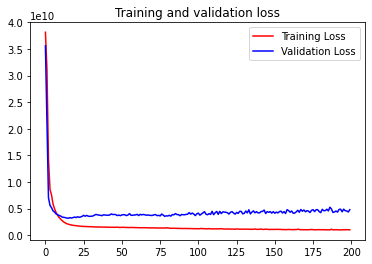

In [ ]:
# result of the model training

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
value_pred = model.predict(df_test.values)

In [ ]:
submission_file = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/sample_submission.csv")

submission_file.drop(['SalePrice'], axis=1, inplace=True)
submission_file['SalePrice'] = value_pred
submission_file.head()

,Id,SalePrice
0,1461,129652.835938
1,1462,139902.843750
2,1463,195730.890625
3,1464,194056.671875
4,1465,163497.656250


In [ ]:
from google.colab import files
submission_file.to_csv('sample_submission.csv', index=False) 
files.download('sample_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>